# Feature View on Data Cubes

In the Earth observation domain, a coverage should be seen a thematic, spatio-temporal attribute of a feature, as it is also defined in the General Feature Model. A coverage is attached to one (or more?) features as the surface of the Earth is attached to the Earth itself. A field, in most cases represented as coverage, e.g., colour, has no-data values: it either exists or does not exist. In the broadest sense a coverage, covering the whole Earth is attached to the feature Earth, the colour variance within Africa is attached to the feature Africa, the temperature variance of an agricultural field is attached to the agricultural field as a feature.

An example of a coverage (temperature) as an attribute of a feature (the oceans of the Earth):
![](https://upload.wikimedia.org/wikipedia/commons/4/40/SST_20131220_blended_Global.png)

According to the General Feature Model, a coverage can be seen as a spatially varying attribute within a feature. In contrast, e.g., a name is a non-spatially varying attribute. There is a connection to spatially intrinsic properties (first case) and spatially extrinsic properties (second case). From Scheider & Huisjes (2018):

> In common understanding, originating in Physics and Chemistry, extensive properties increase with the size
of their supporting objects, while intensive properties are independent of this size

This means, for the Earth observation domain (Wolf, Cox & Portele (2010)):
> Both viewpoints are required since they each express a fundamental meta-model of the world: as a space populated by things, or as a space within which properties vary

%TODO: Temporal Domain: Processes, Events

## Example: Irrigated agriculture in Egypt with Sentinel-2



## 1. Description

Identifying agricultural fields in Egypt with a irrigation system, which is called ["center pivot irrigation"](https://en.m.wikipedia.org/wiki/Center_pivot_irrigation). A rotating sprinkler system generates the typical round areas: ![](https://upload.wikimedia.org/wikipedia/commons/1/17/PivotIrrigationOnCotton.jpg)

Satellite images can be used to document the extent and amount of the fields [as illustrated by this example using images from the Proba-V satellite](https://earth.esa.int/web/guest/missions/esa-operational-eo-missions/proba-v/image-of-the-week/-/article/pivot-irrigation-fields-egypt)

![](https://earth.esa.int/documents/10174/2555664/Proba-V-2014-2016-Pivot-Irrigation-Fields-Egypt-full.jpg)

Images from this area makes it a good testbed for Object-Based Image Analysis (OBIA) in data cubes:
- The resultion of Sentinel-2 is high enough to capture the fields and its details
- Images from this area are not frequently obscurred by clouds
- As shown in the example, the area is quite dynamic and allows to investigate temporal patterns.

This is a simple example, whichs serves as a first test.

## 2. Steps to be completed prior to the analysis

Make sure the file s2-workflow.sh was executed successfully, then import the datacube. The file sets up the data cube, indexes and ingests the provided Sentinel-2A Level 2 images.

In [16]:
%matplotlib inline
import datacube

## 3. Loading data of the study area

Load the datacube and list the available product. The interesting ones are those having the name "s2a_sen2cor_granule", referring to the indexed Sentinel-2 Level 2 Bottom of Atmosphere (BOA) surface reflectance values, and "s2a_sen2cor_granule_ingested_10", referring to the ingested 10 m bands.

In [17]:
dc = datacube.Datacube()
dc.list_products()

,name,description,platform,label,time,format,instrument,lat,creation_time,lon,product_type,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
1,s2a_level1c_granule,Sentinel-2A Level1C - Ortho Rectified Top of A...,Sentinel-2A,None,None,JPEG2000,MSI,None,None,None,S2MSI1C,NaN,NaN,NaN,NaN
3,s2a_sen2cor_granule,Sentinel-2 Level 2 - Sen2Cor Bottom of Atmosph...,SENTINEL_2A,None,None,JPEG2000,MSI,None,None,None,S2MSI2Ap,NaN,NaN,NaN,NaN
4,s2a_sen2cor_granule_ingested_10,Sentinel-2A MSI L2A 10 metre,SENTINEL_2A,None,None,NetCDF,MSI,None,None,None,S2MSI2Ap,EPSG:32635,"(-10, 10)","(100000.0, 100000.0)","(y, x)"
2,s2b_level1c_granule,Sentinel-2B Level1C - Ortho Rectified Top of A...,Sentinel-2B,None,None,JPEG2000,MSI,None,None,None,S2MSI1C,NaN,NaN,NaN,NaN


Load subset of the data cube, which will be referred to as "study area" below. The successful loading of the study area will be indicated by a Dataset type of the xarray module with 1 temporal and two spatial dimensions, whose length is larger than 1 (in space) and larger than 0 (in time). The values are of the type int16 and are not "Nan". The spatial reference system is the original UTM zone with EPSG Code 32635.

In [18]:
study_area = dc.load(
    product = 's2a_sen2cor_granule_ingested_10',
    x = (661741, 693067),
    y = (2449603,2465032),
    crs = 'EPSG:32635')

print(study_area)

<xarray.Dataset>
Dimensions:  (time: 1, x: 3133, y: 1544)
Coordinates:
  * time     (time) datetime64[ns] 2018-10-09T08:50:22.975000
  * y        (y) float64 2.465e+06 2.465e+06 2.465e+06 2.465e+06 2.465e+06 ...
  * x        (x) float64 6.617e+05 6.618e+05 6.618e+05 6.618e+05 6.618e+05 ...
Data variables:
    blue     (time, y, x) int16 1937 1883 1910 1920 1949 1967 1925 1926 1958 ...
    green    (time, y, x) int16 3212 3218 3305 3286 3276 3278 3216 3237 3268 ...
    red      (time, y, x) int16 4844 4790 4914 4904 4973 4930 4806 4800 4830 ...
    nir      (time, y, x) int16 5546 5450 5628 5588 5639 5633 5547 5505 5543 ...
Attributes:
    crs:      EPSG:32635


Calculate the NDVI. The NDVI (Normalized Difference Vegetation Index) can be used to identify the health status of vegetation through the difference of reflection in red and near infrared bands. This is determined by the water content within the cells of the plants, which is a proxy of the health. The NDVI is often used to discriminate between vegetation and non-vegetation by assuming high NDVI values indicate presence of vegetation and low values indicate absence of vegetation. Although, this is not always reliable because other factors can generate high NDVI values as well, it is used in this example:

In [19]:
nir = study_area.nir
red = study_area.red
ndvi = ((nir - red) / (nir + red))

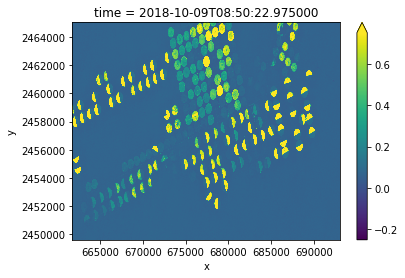

In [20]:
ndvi.plot(vmin=-0.25, vmax=0.75)

## 4. Putting on the glasses with the feature view

### 4.1. Question 1:
How many irrigated agricultural fields are within this area and how many of them are fully used and how many are only partially used?

> A geo-atom is defined as an association between a point location in space–time and
a property.

In [2]:
from rhino import rhino

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


#### 4.1.1. Defining the property

Set the property we want to analyse, in this case the NDVI. Since we want to analyse vegetation vs. non-vegetation, we can define atoms with vegetation as similar and implement it by selecting atoms with values greater than 0.2.

In other words, this is defining the property, which will be used to bind the atoms to features (geo-object), from Goodchild, Yuan & Cova (2007):

> A geo-object is defined as an aggregation of points in space–time whose geo-atoms meet certain requirements, such as having specified values for certain properties

In [14]:
atom_property = rhino.Property("ndvi")
atom_property.setSimilarityFunction(
    {
        "property":"ndvi",
        "value":0.2,
        "operator": "gt"
    })

#### 4.1.2. Defining the neighbourhood

Setting the neighborhood definition, which is used to find the aggregation yielding a feature.

In [15]:
#TODO

#### 4.1.3. Defining the domain

Remember, that a coverage is actually an attribute of a feature, where the attribute is spatially and temporally variable within the domain D of the feature. In most cases, the feature will be there, e.g., as area-of-interest, the shape of the study area, or a administrative entity such as a country. In this case, we create an artificial domain, which is simply a rectangle.

In [ ]:
domain = {
    "type": "rectangle",
    "x":(676388, 680313),
    "y":(2453906,2461794),
    "crs":'EPSG:32635'
}

#### 4.1.4 Adding and analysing the feature view

Load the data cube, this can take a while. In the first step, it simply forwards the load to the ODC datacube, in the second step, it creates the atoms and binds them to a coverage and objects.

In [5]:
dc = rhino.Datacube(show_progress = False, atom_property=atom_property)

dc.load(
    product = "s2a_sen2cor_granule_ingested_10",
    domain = domain
)

At this step, atoms cannot be easily manipulated as we now a coverage-view and a feature-view exists, sharing the same atoms. The different views, just bind them differently. To repeat the quote from above:

The feature-view:
> A geo-object [here: feature] is defined as an aggregation of points in space–time whose geo-atoms meet certain requirements, such as having specified values for certain properties

The coverage-view:
>A geo-field [here: coverage] defines the variation of one or more properties over a domain of space–time D

In other words, the feature-view in this stage already exist, but each atom creates its indivdual object - or each object consists of only one atom. 

However, the result of the aggregation process (binding atoms from different features to a new feature) is a new feature-view and coverage-view. Note, that we do not need parameters as we have defined a property-similarity-function and a neighbourhood-definition-function.

In [6]:
features, coverage, level = dc.execute("aggregation", level = 0)

Plotting the coverage view gives us the NDVI values (remember: "variation of one or more properties") within the extent (remember: "over a domain of space–time D")

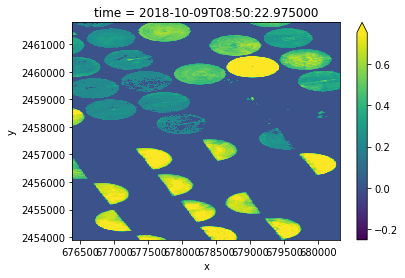

In [8]:
coverage.getStupidArray().plot(vmin=-0.25, vmax=0.75)

Since we also have access to the feature view, we can simply ask how many features were detected

In [9]:
print("Number of features: " + str(len(features)))

Number of objects: 109


We can answer the first part of the question as the algorithm found 109 objects respecting our definition of similarity and neighbourhood. Disclaimer: The Number is obviously too high as some smaller objects are still included. A post-processing using the gestalt-principle is not yet implemented.

Let's have a look at some extrinsic attributes of the features, the area and the compactness:

In [10]:
from geojson import Feature, Polygon, FeatureCollection
geojson_features = []
for i, feat in enumerate(features):
    geojson_features.append(
        Feature(
            geometry=feat.getGeometry(),
            properties={
                "compactness": feat.getAttributeValue('compactness'),
                "area": feat.getAttributeValue('area')}))

In [11]:
import geopandas as gp
geo_data_frame = gp.GeoDataFrame.from_features(geojson_features)

Plotting the area attributes shows the expected outcome that full-circles have a larger area than half-circles, if we neglect the swiss-cheese-effect, the salt-and-pepper-effect and the features crossing the border.

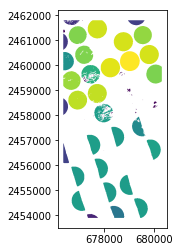

In [12]:
geo_data_frame.plot(column="area")

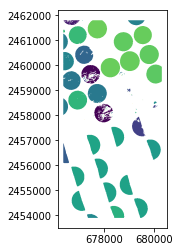

In [13]:
geo_data_frame.plot(column="compactness")

## 4.2 Question 2

When we refer to the General Feature Model, each of the features spans up its own spatio-temporal domain D with a (spatio-temporal) variation of the property, this means, the NDVI coverage becomes a thematic attribute of the feature.

For now, we keep the same definition of property and neighbourhood and have a look at the ndvi value-distribution within the features.